In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
def draw_image(popout=False):
    image = Image.new(mode="RGB", color=(0, 0, 0), size=(image_size, image_size))
    for i in range(m):
        for j in range(m):
            color = (0, 0, 0) if matrix[i, j] else (255, 255, 255)
            for k in range(i*d, i*d + d):
                for l in range(j*d, j*d + d):
                    image.putpixel((k, l), color)
    display(image)
    if popout:
        image.show()

In [4]:
draw_image()

NameError: name 'image_size' is not defined

In [156]:
def count_black_neighbors(mat, x, y):
    return (mat[x-1,y-1] + mat[x-1,y] +
            mat[x-1,y+1])

def count_white_neighbors(mat, x, y):
    return (not mat[x+1,y-1]) + (not mat[x+1,y]) + (not mat[x+1,y+1])

def cell_energy_function(mat, x, y):
    if not mat[x, y]:
        return count_black_neighbors(mat, x, y)
    else:
        return count_white_neighbors(mat, x, y)

def calculate_energy(mat):
    return sum([sum(row) for row in [[cell_energy_function(mat, i, j) for j in range(1, m - 1)] for i in range(1, m - 1)]])

def r(left, right):
    return np.random.randint(left, right)


In [157]:
def generate_neighbor_matrix():
    neighbor = matrix.copy()
    for i in range(m):
        rand_x = r(0, m - 1)
        rand_y = r(1, m - 1)
        neighbor[rand_x, rand_y], neighbor[rand_x, rand_y + 1] = neighbor[rand_x, rand_y+1], neighbor[rand_x, rand_y]

    return neighbor

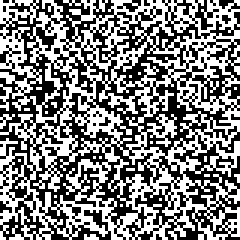

In [5]:
m = 80
image_size = 240
density = 0.5
d = image_size // m
matrix = np.zeros((m, m))
for i in range(m):
    for j in range(m):
        matrix[i, j] = 1 if np.random.rand() < density else 0

draw_image(popout=True)

0


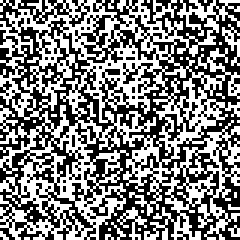

100


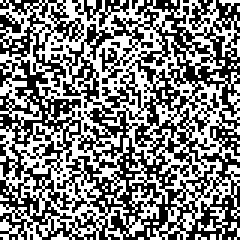

200


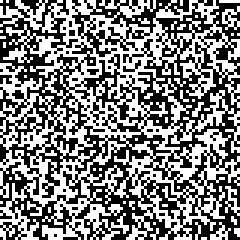

300


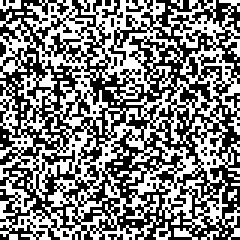

400


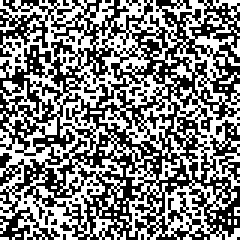

500


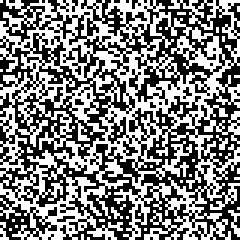

600


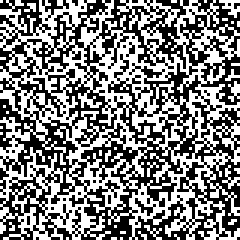

700


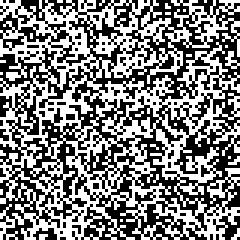

800


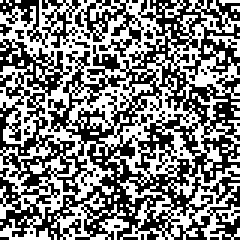

900


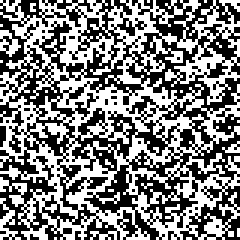

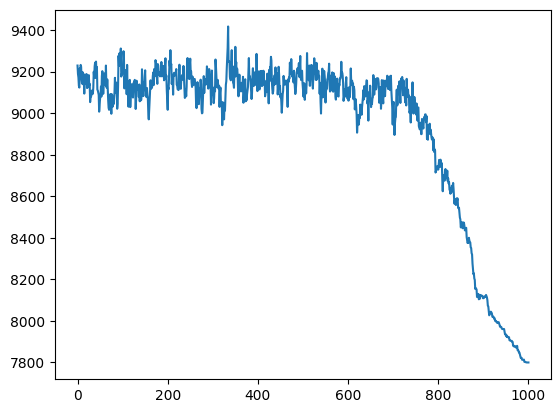

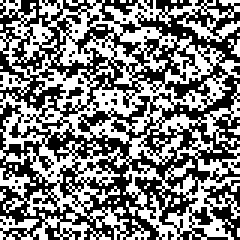

In [159]:
alpha = 0.99
T0 = 10000
T = T0
cur_energy = calculate_energy(matrix)
energy_states = [cur_energy]
steps = 1000
for i in range(steps):
    for _ in range(40):
        new_state = generate_neighbor_matrix()
        next_energy = calculate_energy(new_state)
        if next_energy < cur_energy:
            matrix = new_state
            cur_energy = next_energy
        else:
            p1 = np.exp((cur_energy - next_energy) / T)
            if p1 > np.random.uniform(0, 0.1):
                matrix = new_state
                cur_energy = next_energy
    T = T *alpha
    energy_states.append(cur_energy)
    if i % 100 == 0:
        print(i)
        draw_image()

plt.plot([i for i in range(len(energy_states))], energy_states)
plt.show()
draw_image(popout=True)


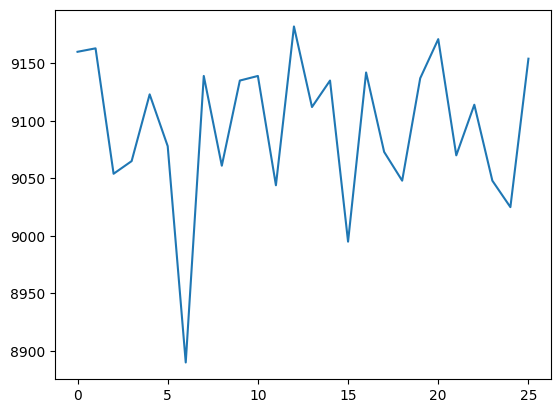

In [150]:
plt.plot([i for i in range(len(energy_states))], energy_states)
plt.show()